Lets say we want to do some text classification and are just starting out with the project. There are some general steps that we can take to make sure we set up the project for sucess!

* Step 1: Get some data
* Step 2: Clean and analyze data
* Step 3: Choose one or more algorithms
* Step 4: Analyze algorithm and choose one for production

We'll go over each of these steps in detail in this notebook using the 20 newsgroup dataset that come preinstalled in sklearn. Note too that there may be other steps you need to consider as well in your own projects, but this is a good start.

In [1]:
# Import packages
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix


%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import pyplot

## Step 1: Get some Data

Get the 20 Newsgroups data is nice bc it is longer text, labeled and just a bit messy
http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups for more info and some good examples.
The first time you run this, the data will be downloaded, but it is fairly small.

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'rec.autos',
    'rec.motorcycles',
    'sci.space'
]

# Removing the headers, footers and quotes only keeps the line information
# The header and footer information in particular have metadata which would cause the algorithm to be overfitted
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, random_state=42, remove=('headers', 'footers', 'quotes'))

# Look to see what the first three entries of the raw data looks like
print(newsgroups_train.data[:3])
print(newsgroups_train.target[:3])

["Hey folks--\n\nI've got a pair of Dunlop sportmax radials of my ZX-10, and they've been\nvery sticky (ie no slides yet), but all this talk about the Metzelers has\nme wondering if my next set should be a Lazer comp K and a radial Metzeler\nrear...for hard sport-touring, how do the choices stack up?", "From article <eabu288-140493210752@dialin33635.slip.nts.uci.edu>, by eabu288@orion.oac.uci.edu (Alvin):\n\n--Could be.  Isn't the 2.5 liter six supposed to be enlarged to 2.8 liters\n  in the not-too-distant future?\n\n--Aamir Qazi\n\n-- ", '\n\nI agree.  Six hour long stretches behind the wheel really make me\nthirsty, especially for something with caffeine.  I consider it a\nfailing of my car that it has no cup holder nor anywhere to put a cup\nholder.']
[1 0 0]


## Step 2: Clean and analyze data

### Analyzing any potential dataset biases

Now that we have the data we want to make sure that it is balanced. Unbalanced datasets can cause algorithms to be biased - favoring the classification of one class over another. We can count the number of each type of label, or view the labels as a histogram. If the dataset is unbalanced, then remedial measures can be utilized to balance the classes out. Alternatively, many algorithms (including PyTorch) let you give weights to the classes in order to help the algorithm be less biased.

A nice feature of the 20 newsgroup dataset is that it is balanced, but it is important to always look at the breakdown of your data before trying to build a classifier for it.

When looking at a dataset it is also important to know how the dataset was collected and labeled as this has some very real implications to your final algorithm. For instance, if the space articles were only collected on conversations surrounding studying star formation, the classifier would likely not be able to as accuratly classify articles on Martian exploration. It is very important to make sure that your use case matches the intended/expected use of the dataset.

(array([594.,   0.,   0.,   0.,   0., 598.,   0.,   0.,   0., 593.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

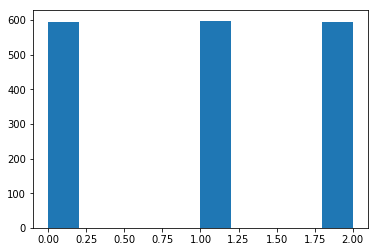

In [3]:
plt.hist(newsgroups_train.target)

(array([396.,   0.,   0.,   0.,   0., 398.,   0.,   0.,   0., 394.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

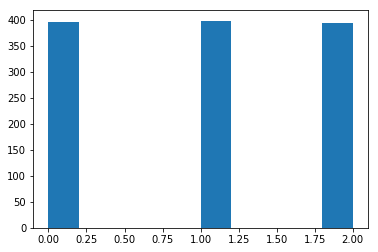

In [4]:
plt.hist(newsgroups_test.target)

### Cleaning the dataset

Now that we know the dataset is ok we would like to clean the text. In NLP there are few typical cleaning techniques that are used for many tasks. However, these are definitely task dependent! For example, if you are performing name entity recognition (NER), your more than likely do not want to lowercase your text.

* Lowercase
* Remove stopwords (a, and, the, but...)
* Removing non-letters
* Cleaning or removing web addresses, hashtags, dates, etc
* Lemmatization (in essence get the root of the word)


In [5]:
lemmatizer = WordNetLemmatizer()


def lemmatize(word, lemma=lemmatizer):
#     This function will take a single word and return the lemma of it
#     Examples:
#         running -> run
#         awkwardly -> awkward

#     Transforming text in this way allows for better topic prediction
#     as topics will probably contain the same root words and we don't 
#     care about the tense the topic is being discussed in.
    
    lemmatized = lemma.lemmatize(word, "n")
    if lemmatized == word:
        lemmatized = lemma.lemmatize(word, "v")
    if lemmatized == word:
        lemmatized = lemma.lemmatize(word, "r")
    return lemmatized


def clean_text(raw_text, remove_stop_words=True,  lemmatize_words=True):
    # Function to clean text
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    # This is modified from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

    # 1. Keep only letters or numbers        
    letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_text) 
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()  
    
    # 3. If we want to not remove stop words we are done - otherwise forge ahead
    if remove_stop_words == False:
        return words
    
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words, lemnitizing as we go if desired
    if not lemmatize_words:
        meaningful_words = [w for w in words if not w in stops]   
    else:
        meaningful_words = [lemmatize(w) for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result 
    return( " ".join( meaningful_words ))  


In [6]:
# what does the full text clean look like:
print(newsgroups_train.data[0], '\n')
print("Without stopwords \n")
print(clean_text(newsgroups_train.data[0], remove_stop_words=True, lemmatize_words=False))
print("\n Without stopwords and with lemmatization \n ")
print(clean_text(newsgroups_train.data[0], remove_stop_words=True, lemmatize_words=True))

Hey folks--

I've got a pair of Dunlop sportmax radials of my ZX-10, and they've been
very sticky (ie no slides yet), but all this talk about the Metzelers has
me wondering if my next set should be a Lazer comp K and a radial Metzeler
rear...for hard sport-touring, how do the choices stack up? 

Without stopwords 

hey folks got pair dunlop sportmax radials zx 10 sticky ie slides yet talk metzelers wondering next set lazer comp k radial metzeler rear hard sport touring choices stack

 Without stopwords and with lemmatization 
 
hey folk get pair dunlop sportmax radial zx 10 sticky ie slide yet talk metzelers wonder next set lazer comp k radial metzeler rear hard sport tour choice stack


## Step 3: Choose one or more algorithms

Now that we have a clean dataset which we have determined is balanced, and fits our use case, we can choose one or more algorithms to experiment with. We are going to start with a very simple model as the later lessons will go into more of the deep learning techniques. So the very first model we will try is a bag of words model (BOW) with Term Frequency, Inverse Document Frequency (TF-IDF) into a logistic regression. 

Basically, BOW will count the number of each words occurance. TF-IDF will then weight the words that occur less frequenty in the overal corpus (aka all of our documents) so that the more infrequent words have a higher count. SKlearn has a built in function TfidfVectorizer() that we will use. One aspect to not here is that TfidfVectorizer() can remove stop words at this stage as well, but we already took care of that step in cleaning. As a side note, it definitely is not as important to remove stop words when using TF-IDF as the most frequent words are discounted naturally due to the number of times they appear in the corpus.

In [7]:
tf_idf_vectorizer = TfidfVectorizer(analyzer = "word", stop_words = None, max_features = 5000)
# Max features here is how many tokens to include in the corpus (aka number of "words")

clean_train = [clean_text(article) for article in newsgroups_train.data]
train_data_features = tf_idf_vectorizer.fit_transform(clean_train)
train_data_features = train_data_features.toarray()

# At this point I like to look at the data again just to see what it looks like now
print(train_data_features.shape)
print(train_data_features[:5])

(1785, 5000)
[[0.         0.         0.         ... 0.         0.         0.21486039]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
# Lets use a very simple model as well - that of logistic regression
logreg = linear_model.LogisticRegression()
logreg.fit(train_data_features, newsgroups_train.target)

# model is trained so we test - make sure when you fit the vectorizer you only transform
# not fit_transform as we don't want to retrain the vectorizer

clean_test = [clean_text(article) for article in newsgroups_test.data]
test_data_features = tf_idf_vectorizer.transform(clean_test)
test_data_features = test_data_features.toarray()

predictions = logreg.predict(test_data_features)

## Step 4: Analyze algorithm and choose one for production

There are a number of ways to analyze the algorithm once it is trained. One method that I often use is a classification report. In this report you get the precision, recall, and f1-score for each of the classes. According to Wikipedia https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg the precision answers the question "How many selected items are relevant" while recall answers "How many relevant items are selected". 

![alt text](Precisionrecall.svg)

The F1 Score is the harmonic mean of precision and recall.

Unsurprisingly, the classifier was able to have the best acuracy on the space articles compared to autos and mortocycles as those two classes are much closer together.

Splitting the data into a training and a test set helps to ensure that we aren't overfitting, but it is informative to see how different the classifier is able to predict the training set, as opposed to the test set that it didn't see. And indeed if we look at the table below the performance is higher with the training set. It isn't a lot of overfitting, but could be improved. The image from http://cs231n.github.io/neural-networks-3/ is a good example of how to judge overfitting, particularly with deep learning models.

![alt text](accuracies.jpeg)

In [9]:
print(classification_report(newsgroups_test.target, predictions, target_names=newsgroups_train.target_names))

                 precision    recall  f1-score   support

      rec.autos       0.85      0.81      0.83       396
rec.motorcycles       0.79      0.83      0.81       398
      sci.space       0.90      0.89      0.89       394

    avg / total       0.85      0.85      0.85      1188



In [10]:
train_predictions = logreg.predict(train_data_features)
print(classification_report(newsgroups_train.target, train_predictions, target_names=newsgroups_train.target_names))

                 precision    recall  f1-score   support

      rec.autos       0.97      0.92      0.94       594
rec.motorcycles       0.90      0.97      0.94       598
      sci.space       0.99      0.97      0.98       593

    avg / total       0.95      0.95      0.95      1785



### Explaining the classifier - which words is it relying on most heavily?

Another aspect that may be important with assessing and choosing an algorithm, is to gain an intuition around why a certain classification was chosen. For deep learning models, attention layers are being utilized to see the top words a classifier relied on to make its decision. A similar method is used in machine learning. Explainability for NLP is an active topic of research, but they are getting more robust.

In [11]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(logreg, tf_idf_vectorizer, newsgroups_train.target_names)

rec.autos: wagon gt oil price toyota drive ford dealer auto car
rec.motorcycles: bmw drink rider dog rid helmet ride dod motorcycle bike
sci.space: program satellite fund rocket earth moon nasa orbit launch space


## Try it with your own text

One of the useful (and fun) things to do now if to see how the classifier will parse new text that it hasn't seen. So write a sentence and see what happens. You can also go back and do all 20 categories.

In [12]:
text_input = "I always loved watching the stars, and whenever I have the change I watch for satellites overhead :)"

In [23]:
clean_input = [clean_text(text_input)]
input_data_features = tf_idf_vectorizer.transform(clean_input)
input_data_features = input_data_features.toarray()

input_prediction = logreg.predict(input_data_features)
prediction_percentage = max(logreg.predict_proba(input_data_features))*100
print("This text most fits in %s with a probability of %f" 
      %(newsgroups_train.target_names[input_prediction[0]],prediction_percentage[0] ))

This text most fits in sci.space with a probability of 22.281605


## Exercise Complete!

This is the bare bones of an end-to-end analysis we can save the models. From here we can experiment with using a CountVectorizer() instead of the TfidfVectorizer(), using a different algorithm like an boosted tree, an LSTM, or a CNN. We can also play around with how we cleaned the data. Did we really want to remove stop words, or how important was lemmitization? These are all things we could experiment with and see how the results change.

This notebook approached many of the aspects necessary to ensure that the algorithm being created is ethical. The folks over at DrivenData have create the checklist below that can act as a guide as you go through your project. For more information on how to install and utilize this checklist goto: http://deon.drivendata.org/

-----


# Data Science Ethics Checklist

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have those subjects have given informed consent, where users clearly understand what they are consenting to and there was a mechanism in place for gathering consent?
 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
 - [ ] **A.3 Limit PII exposure**: Have we considered ways to to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

## B. Data Storage
 - [ ] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?
 - [ ] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?
 - [ ] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?

## C. Analysis
 - [ ] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?
 - [ ] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?
 - [ ] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?
 - [ ] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?
 - [ ] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

## D. Modeling
 - [ ] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?
 - [ ] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?
 - [ ] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?
 - [ ] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?
 - [ ] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?

## E. Deployment
 - [ ] **E.1 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?
 - [ ] **E.2 Roll back**: Is there a way to turn off or roll back the model in production if necessary?
 - [ ] **E.3 Concept drift**: Do we test and monitor for concept drift to ensure the model remains fair over time?
 - [ ] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*
